<font size=4><span style='font-family:Georgia'>Mean reverting or staionary financial price series are unfortunately rare in real life. However, as we combine assets whose prices are correlated in certain ways, we can construct a porfolio with a stationary market value. The technique is called *cointegration*, and the fabriated price series are called *cointegrated*. Here, we will first explore the stationarity of a cointegrated series of two assets using both Augmented Dickey-Fuller Test, and backtest a mean-reverting strategy on a porforlio cointegrated by three assets.</span></font>

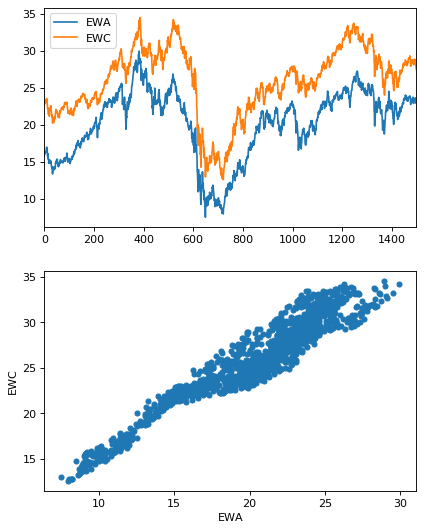

In [214]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline
#the assets we use here are:
#EWA: iShares MSCI Australia ETF       EWC: iShares MSCI Australia ETF     IGE: iShares North American Natural Resources ETF
ETF_df = pd.read_csv("inputData_ETF.csv", header=None, names=["EWA", "EWC", "IGE"])

#plot graphs to get intuition in the relationship between the two assets
fig=plt.figure(figsize=(6, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(2,1,1)
ax1 = plt.gca()
ETF_df.plot(kind="line", y="EWA", ax=ax1)
ETF_df.plot(kind="line", y="EWC", ax=ax1)
plt.subplot(2,1,2)
ax2 = plt.gca()
ETF_df.plot(kind="scatter", x="EWA", y="EWC", ax=ax2)
plt.show()

<font size=4><span style='font-family:Georgia'>As we can see from the graphs, the two ETF, EWA and EWC, have similar trend during the period, as both Canadian and Australian economies are commodity based, it is likely that they show the same pattern in the global market.</span></font>
    
<font size=4><span style='font-family:Georgia'>However, a strong covariance does not guarantee any combination of the assets would form a stationary series (though very useful to it). We will use linear regression to find the optimal hedge ratio</span></font> 

<font size=4><span style='font-family:Georgia'>Why the optimal hedge ratio is determined by coefficient of linear regression? My intuitive interpretation: in making up a stationary series, we are actually using the highly positive of negative relations between assets to "offset" changes in the other assets in hope to find a stationary porfolio value around 0. As in linear regression provide the best approximation to the target value we are going to offset, the negative of it adding to the porfolio approximates the total value to 0 most. Otherwise, any other combination covers a smaller proportion of the target price, as the target price goes high, the residual also scales, making the total value deviates farther from zero, and less likely to be a stationary series.</span></font>

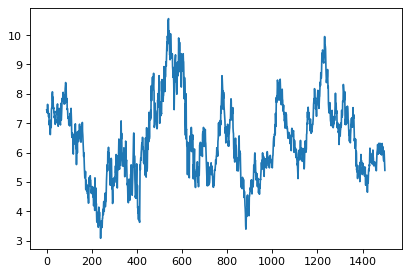

In [215]:
from sklearn.linear_model import LinearRegression

linearModel = LinearRegression()
EWA_df = ETF_df[["EWA"]]
EWC_df = ETF_df[["EWC"]]
IGE_df = ETF_df[["IGE"]]

#a notable point here is that linear regression in scikit-learn will automatically add scalar term 1 to the X variables, so we do not need to add
#an array of ones as we do in matlab
linearModel.fit(EWA_df.values, EWC_df.values) 
hedgeRatio = linearModel.coef_[0,0]
stationarySeries = EWC_df.values- EWA_df.values*hedgeRatio
fig=plt.figure(figsize=(6, 4), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(stationarySeries)
plt.show()

<font size=4><span style='font-family:Georgia'>The series looks stationary as it fluctuates around a mean value. We are going to test its stationarity by a more rigorous statistical test. Mathematically, we can describe the price change using a linear model:
    $$\Delta y(t)=\lambda y(t-1)+\mu + \beta t + \alpha_1 \Delta y(t-1) + ... +\alpha_k \Delta y(t-k) + \varepsilon_t$$
where $\mu$ is the mean value of the series, and $\beta$ is the natural drift of the price of asset. Because the drift is far smaller than magnitude of daily fluctuation of price, we will ignore it and set it to 0. The purpose of the test is to reject the null hypothesis that $\lambda$ is not zero, so that the stationary alternative hypothesis is valid.</span></font>

In [216]:
import statsmodels.tsa.stattools as ts

cadf = ts.adfuller(stationarySeries.reshape(-1),maxlag=1)
print(cadf)

(-3.6422479807847297, 0.0050028483243865635, 1, 1498, {'1%': -3.4347228578139943, '5%': -2.863471337969528, '10%': -2.5677982210726897}, 550.2164129635376)


<font size=4><span style='font-family:Georgia'>According to the ADF test, the t-statistic is -3.642 which is smaller than 0.01 significance level. In other words, it has a 99% certainty that EWC and EWA prices are cointegrating.
Note that in both regression and ADF test we choose EWC to be dependent variable, and EWA to be independent. Counter-intuitively, if we reverse two sets of data, the ADF test will show different results. That is to say, only exists only one hedge ratio will lead to stationary porfolio. So, strictly speaking, with ADF test, we should do multiple test to determine best ratio. Luckily, we can avoid this using Johansen Test.</span></font>

In [217]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

twoVar = np.array(ETF_df[['EWC','EWA']])
johansen2var = coint_johansen(twoVar, det_order=0, k_ar_diff=1)
print("Trace statistic", johansen2var.lr1)
print("Critical value for trace statistic","\n", johansen2var.cvm)
print("\n", "Eigen statistic", johansen2var.lr2)
print("Critical value for Eigen statistic","\n", johansen2var.cvm)

Trace statistic [19.98321869  3.98276124]
Critical value for trace statistic 
 [[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]

 Eigen statistic [16.00045745  3.98276124]
Critical value for Eigen statistic 
 [[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]


<font size=4><span style='font-family:Georgia'>In fact, Johansen Test is a generalized version of ADF Test used for multiple variables. The linear model is generalized:
$$\Delta y(t)=\Lambda y(t-1)+ M + \beta t + A_1 \Delta Y(t-1) + ... +A_k \Delta Y(t-k) + \varepsilon_t$$
Here, $\Lambda$ and $A$ are in matrix form. Denote the rank of matrix $\Lambda$ to be r, the number of price series to be n, then the number of independent portfolios that can be formed by various linear combinations of the cointegrating price series is equal to r. The Johansen test will calculate r for us in two diff erent ways, both based on eigenvector decomposition of $\Lambda$. One test produces the so-called trace statistic, and other produces the eigen statistic. We can see the t-statistics for EWC-EWA series are greater than at least 0.05 significance level in both cases.</span></font>

In [218]:
threeVar = np.array(ETF_df[['EWC','EWA','IGE']])
johansen3var = coint_johansen(threeVar, det_order=0, k_ar_diff=1)
print("Eigen statistic", johansen3var.lr2)
print("Critical value for Eigen statistic","\n", johansen3var.cvm)
print("\n","eigenvalues for shortest half life","\n", johansen3var.eig)

Eigen statistic [16.89690127 13.06069841  4.47102054]
Critical value for Eigen statistic 
 [[18.8928 21.1314 25.865 ]
 [12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]

 eigenvalues for shortest half life 
 [0.01121626 0.00868086 0.00298021]


<font size=4><span style='font-family:Georgia'>Furtherly, we will add IGE prices to the porfolio to make it a real multivariate case. The test on Eigen statistic that we can have three cointegrating relations with 95% certainty. More interestingly, the eigenvectors found by Johansen Test can be used as hedge ratio for the individual price series to form a stationary porfolio. Although there should be r sets of such vectors, only one of them builds strongest porfolio. We will put that into practice and see its effect in backtest.</span></font>

In [219]:
from sklearn.impute import SimpleImputer
import math
imputer = SimpleImputer()
#retrieve the eigenvector, note that the first column of eigenvector matrix is the strongest coefficient for the porfolio
eigenvector = johansen3var.evec[:,0].T.reshape((1,johansen3var.evec[:,0].size)) 
coefficientMatrix = np.repeat(eigenvector, threeVar.shape[0], axis=0) #get a coefficient matrix fitting the size of price variables
porfolio = np.sum(coefficientMatrix*threeVar,axis=1).reshape((1500,1)) #calculate the total value of porfolio at all time stamps
porfoliolag = pd.DataFrame(porfolio).shift().values.reshape((1500,1))
delta = porfolio - porfoliolag
delta = imputer.fit_transform(delta) #fill the NaN entry for linear regression model
porfoliolag = imputer.fit_transform(porfoliolag)
linearModel.fit(porfoliolag, delta)
halflife = -math.log(2) / linearModel.coef_[0,0] #calculate the half life for mean reverting process
print("The halflife of the reverting is", halflife, "days")

The halflife of the reverting is 22.662577850489182 days


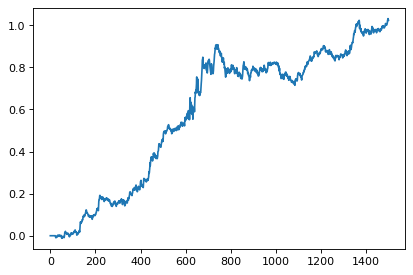

APR= 0.1257386810077381 
Sharpe Ratio= 1.3917740903422229


In [220]:
lookback = math.ceil(halflife)
porfolioMovingAvg= pd.DataFrame(porfolio).rolling(lookback).mean()
porfolioMovingStd = pd.DataFrame(porfolio).rolling(lookback).std()
numUnits = -(porfolio-porfolioMovingAvg) / porfolioMovingStd #capital to invest at various time stamps
positions = np.repeat(numUnits.values, threeVar.shape[1], axis=1)*coefficientMatrix*threeVar #positions at various time stamps
threeVarlag = pd.DataFrame(threeVar).shift().values
positionslag = pd.DataFrame(positions).shift().values
pnl = np.sum(positionslag*(threeVar - threeVarlag) / threeVarlag, axis=1) #daily profit and loss
ret = pnl / np.sum(abs(positionslag), axis=1) #daily return
ret[np.isnan(ret)] = 0 #where there is NaN entry, no transaction happened
cumProfit = np.cumprod(1+ret)-1 #calculate cumulative profit
fig=plt.figure(figsize=(6, 4), dpi= 80, facecolor='w', edgecolor='k') #plot the result
plt.plot(cumProfit)
plt.show()
APR = np.power(np.prod(1+ret),252/ret.size)-1
SharpeRatio = np.sqrt(252)*np.mean(ret)/np.std(ret)
print("APR=",APR,"\nSharpe Ratio=",SharpeRatio)

<font size=4><span style='font-family:Georgia'>From the backtest above, the mean reverting strategy looks quite profitable with a nearly 100% return. However, all this is based of ideal condition. In reality, we cannot really enter and exit an infi nitesimal number of shares whenever the price moves by an infi nitesimal amount. Most importantly, the test is conducted with in-sample data (based on we which we get lookback), and we can hardly get that quantity in practical trading. However, the simplicity of mean-reverting strategy is demonstrated: We are not limited to real stationary price series, rather, we can be imaginative to construct them. Also, we will not be exhausted by problems invovling data, as it does not have any parameter to optimize at all.</span></font>